**Import Packages/Necessities**

In [75]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [72]:
from matplotlib import rcParams
from matplotlib import cycler

**Load data from processed CSV**

In [34]:
# Consider data and most common diseases.

# Load metadata
df = pd.read_csv("vinbigdata/train.csv")

# View unique disease labels
print("Unique Labels:", df["class_name"].unique())
print("Label Distribution:\n", df["class_name"].value_counts())

Unique Labels: ['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening'
 'ILD' 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis'
 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification'
 'Consolidation' 'Pneumothorax']
Label Distribution:
 class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64


**Create dataframe and mapping**

As mentioned in the project outline, I'm currently considering the top 6 most
prevalent diseases.

In [35]:
# Only examine top 5 most relevant diseases (6 categories including no finding)

class_map = {
    "No finding": 0,
    "Cardiomegaly": 1,
    "Nodule/Mass": 2,
    "Lung Opacity": 3,
    "Pleural effusion": 4,
    "Consolidation": 5
}

# Filter dataset to include only these 6 classes
df_filtered = df[df["class_name"].isin(class_map.keys())].copy()
df_filtered["label"] = df_filtered["class_name"].map(class_map)
existing_images = set(os.listdir("vinbigdata_resized"))
df_filtered = df_filtered[df_filtered["image_id"].apply(lambda x: f"{x}.jpg" in existing_images)]

# Save updated metadata
df_filtered.to_csv("vin_labeled.csv", index=False)

print(f"Filtered dataset of {len(df_filtered)} images")

Filtered dataset of 12874 images


Getting rid of duplicates in the CSV

In [36]:
# Metadata
df = pd.read_csv("vin_labeled.csv")

# Check how many unique images exist in metadata
print(f"Total rows in CSV: {len(df)}")
print(f"Unique images in CSV: {df['image_id'].nunique()}")

df_unique = df.drop_duplicates(subset=["image_id"])

# Save cleaned dataset
df_unique.to_csv("vinbigdata_labeled.csv", index=False)

print(f"Cleaned dataset saved with {len(df_unique)} unique images.")
print(f"New Total rows in CSV: {len(df)}")
print(f"New Unique images in CSV: {df['image_id'].nunique()}")


Total rows in CSV: 12874
Unique images in CSV: 3204
Cleaned dataset saved with 3204 unique images.
New Total rows in CSV: 12874
New Unique images in CSV: 3204


**Properly grayscale images and normalize in tensors. (Already 224x224) from processing**

In [37]:
# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

**Dataset loader**

In [38]:

class XRayDataset(Dataset):
    def __init__(self, image_folder, csv_file):
        self.image_folder = image_folder
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_id"] + ".jpg")
        image = Image.open(img_path)
        image = transform(image)
        label = torch.tensor(row["label"], dtype=torch.long)
        return image, label

Making sure that the sizes make sense and that the split properly works

In [39]:
full_dataset = XRayDataset("vinbigdata_resized", "vinbigdata_labeled.csv")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
                                          
print(f"Dataset size: {len(full_dataset)}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Dataset loaded with {len(full_dataset)} images")
print(f"Train loaded with: {len(train_dataset)} images")
print(f"Validation loaded with: {len(val_dataset)} images")

Dataset size: 3204
Train size: 2563
Validation size: 641
Dataset loaded with 3204 images
Train loaded with: 2563 images
Validation loaded with: 641 images


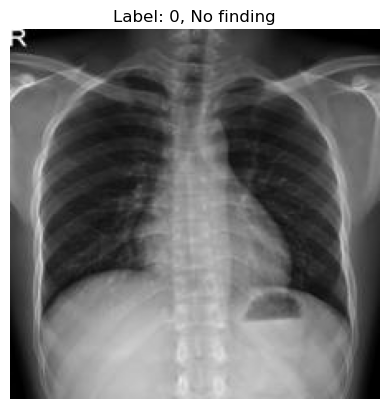

In [65]:
# Print an image from the dataset
def show_image(image, label):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)

    # map label to disease name as well
    plt.title(f"Label: {label}, {list(class_map.keys())[list(class_map.values()).index(label.item())]}")
    plt.axis('off')
    plt.show()

# Show a sample image from full dataset
show_image(*full_dataset[0])

**Helper functions for more efficient model creation/loading and training of multiple models**

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_resnet(num_classes = 6):

    # Modify the last fully connected layer for 6-class classification
    resnet = models.resnet18(pretrained=True)
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    return resnet

def train_model(model, data_loader, num_epochs=5):
    model = model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(data_loader):.4f}")


**Models trained on the entire dataset (likely will generalize better to OOD data)**

In [41]:
model_list = []
num_models = 3

for i in range(num_models):
    print(f"Training model {i+1}/{num_models}")
    model = create_resnet()
    train_model(model, full_loader, num_epochs=5)
    model_list.append(model)
    torch.save(model.state_dict(), f"vin_model_{i+1}.pth")

Training model 1/3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 1.4104
Epoch 2/5, Loss: 1.0497
Epoch 3/5, Loss: 0.8765
Epoch 4/5, Loss: 0.6642
Epoch 5/5, Loss: 0.4851
Training model 2/3
Epoch 1/5, Loss: 1.3957
Epoch 2/5, Loss: 1.0391
Epoch 3/5, Loss: 0.8506
Epoch 4/5, Loss: 0.6744
Epoch 5/5, Loss: 0.4698
Training model 3/3
Epoch 1/5, Loss: 1.3978
Epoch 2/5, Loss: 1.0437
Epoch 3/5, Loss: 0.8513
Epoch 4/5, Loss: 0.6663
Epoch 5/5, Loss: 0.4867


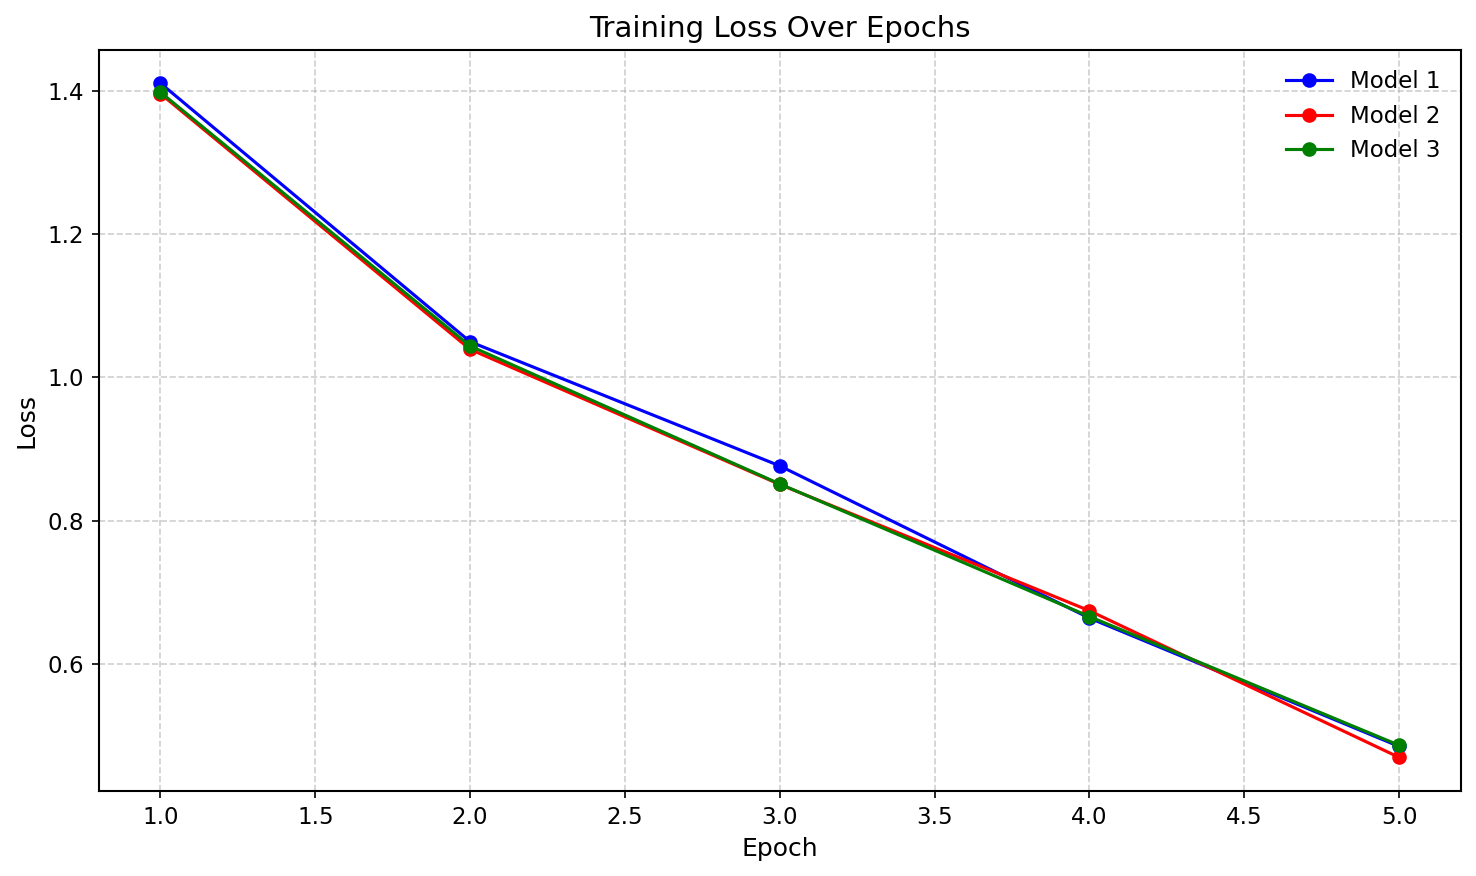

In [91]:
epochs = [1, 2, 3, 4, 5]
loss_model_1 = [1.4104, 1.0497, 0.8765, 0.6642, 0.4851]
loss_model_2 = [1.3957, 1.0391, 0.8506, 0.6744, 0.4698]
loss_model_3 = [1.3978, 1.0437, 0.8513, 0.6663, 0.4867]


plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_model_1, label='Model 1', marker='o', color='blue')
plt.plot(epochs, loss_model_2, label='Model 2', marker='o', color='red')
plt.plot(epochs, loss_model_3, label='Model 3', marker='o', color='green')

plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Model with training/validation split in order to determine more accurate results?**

In [42]:
# Training the partial models using 80/20 split for train/validation

partial_models = []
num_models = 3

for i in range(num_models):
    print(f"Training 80/20 model {i+1}/{num_models}")
    model = create_resnet()
    train_model(model, train_loader, num_epochs=5)
    partial_models.append(model)
    torch.save(model.state_dict(), f"vin_partial_model_{i+1}.pth")
    

Training 80/20 model 1/3
Epoch 1/5, Loss: 1.4416
Epoch 2/5, Loss: 1.0864
Epoch 3/5, Loss: 0.9053
Epoch 4/5, Loss: 0.7067
Epoch 5/5, Loss: 0.5141
Training 80/20 model 2/3
Epoch 1/5, Loss: 1.4368
Epoch 2/5, Loss: 1.0857
Epoch 3/5, Loss: 0.8781
Epoch 4/5, Loss: 0.6800
Epoch 5/5, Loss: 0.4566
Training 80/20 model 3/3
Epoch 1/5, Loss: 1.4537
Epoch 2/5, Loss: 1.0903
Epoch 3/5, Loss: 0.9011
Epoch 4/5, Loss: 0.6956
Epoch 5/5, Loss: 0.5012


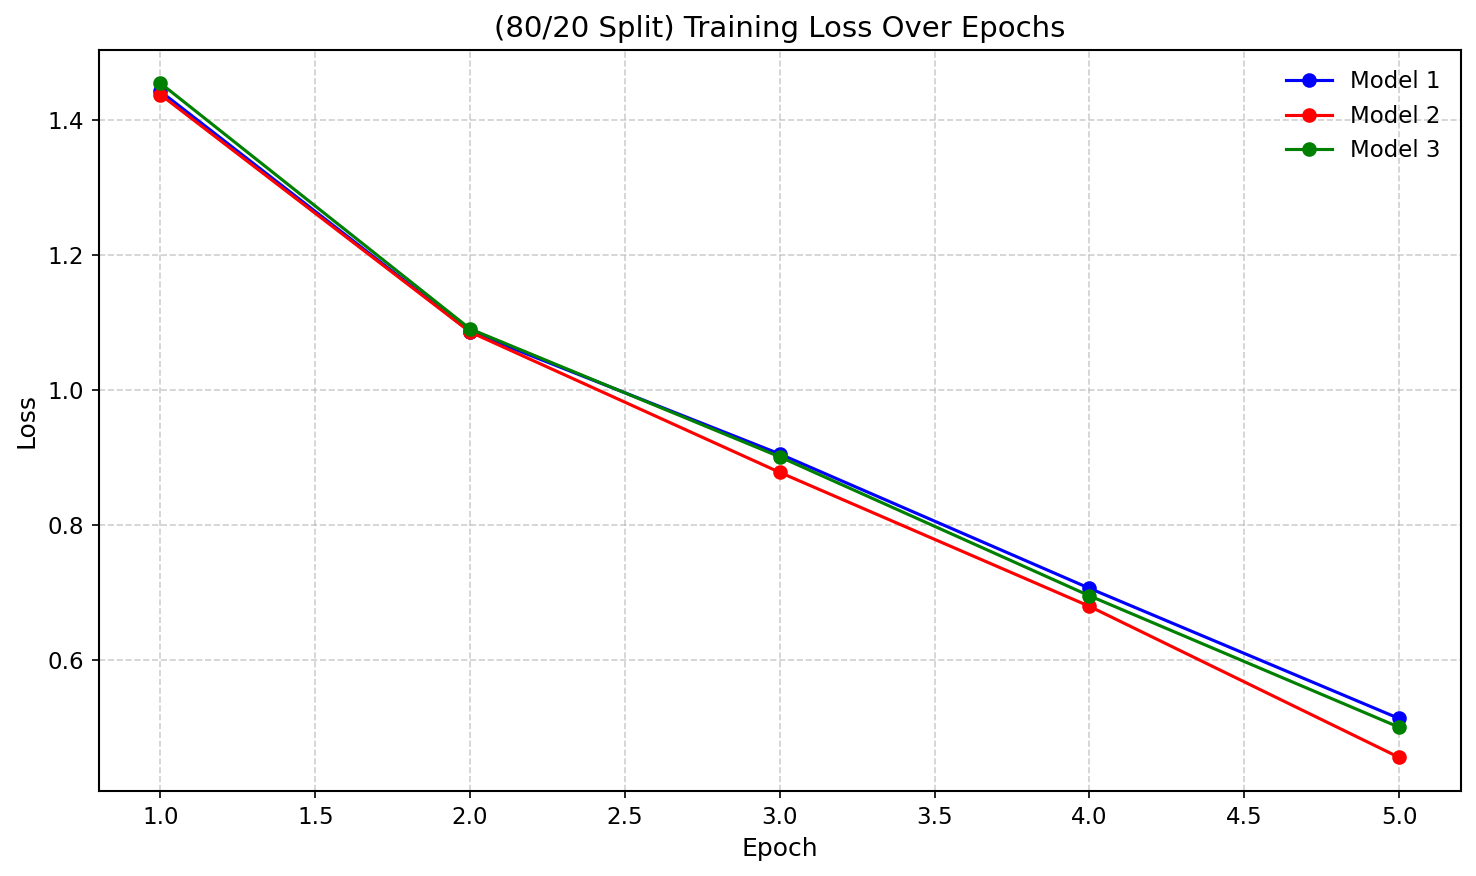

In [92]:
epochs = [1, 2, 3, 4, 5]
loss_8020_model_1 = [1.4416, 1.0864, 0.9053, 0.7067, 0.5141]
loss_8020_model_2 = [1.4368, 1.0857, 0.8781, 0.6800, 0.4566]
loss_8020_model_3 = [1.4537, 1.0903, 0.9011, 0.6956, 0.5012]


plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_8020_model_1, label='Model 1', marker='o', color='blue')
plt.plot(epochs, loss_8020_model_2, label='Model 2', marker='o', color='red')
plt.plot(epochs, loss_8020_model_3, label='Model 3', marker='o', color='green')

plt.title('(80/20 Split) Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Ensembling of models**

Potentially explore bagging/boosting training as well? Model training has been a significant bottleneck in progress

In [43]:
# Ensemble method (average predictions)

def ensemble_predict(models, image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    softmax = nn.Softmax(dim=1)
    outputs = [softmax(m(image_tensor)).detach().cpu().numpy() for m in models]
    avg_output = np.mean(outputs, axis=0)
    return avg_output

**Load models from save (because I messed it up earlier and don't want to retrain)**

In [ ]:
# model_list = []

# for i in range(3):
#     model = create_resnet()
#     model.load_state_dict(torch.load(f"vin_model_{i+1}.pth"))
#     model.to(device)
#     model.eval()
#     model_list.append(model)

# partial_models = []

# for i in range(3):
#     model = create_resnet()
#     model.load_state_dict(torch.load(f"vin_partial_model_{i+1}.pth"))
#     model.to(device)
#     model.eval()
#     partial_models.append(model)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Evaluation of models + accuracies**

In [70]:
# Evaluate the ensemble model by averaging predictions using softmax
def evaluate(models, dataset, class_names=None):
    for model in models:
        model.eval()
    all_preds = []
    all_true = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for img, label in dataset:
            image_tensor = img.unsqueeze(0).to(device)
            outputs = [softmax(m(image_tensor)).cpu().numpy() for m in models]
            avg_output = np.mean(outputs, axis=0)
            pred = np.argmax(avg_output)
            all_preds.append(pred)
            all_true.append(label)
    
    acc = accuracy_score(all_true, all_preds)
    prec = precision_score(all_true, all_preds, average='weighted')
    rec = recall_score(all_true, all_preds, average='weighted')
    f1 = f1_score(all_true, all_preds, average='weighted')

    per_class_prec = precision_score(all_true, all_preds, average=None)
    per_class_rec = recall_score(all_true, all_preds, average=None)
    per_class_f1 = f1_score(all_true, all_preds, average=None)

    if class_names:
        print("\nClassification Report:")
        print(classification_report(all_true, all_preds, target_names=class_names))

    cm = confusion_matrix(all_true, all_preds)
    
    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "per_class_prec": per_class_prec,
        "per_class_rec": per_class_rec,
        "per_class_f1": per_class_f1,
        "confusion_matrix": cm,
        "true": all_true,
        "preds": all_preds,
    }

In [71]:
# Full data ensemble
baseline_metrics = evaluate([model_list[0]], full_dataset)
ensemble_metrics = evaluate(model_list, full_dataset)

print(f"Full-data single model accuracy: {baseline_metrics['acc']:.4f}")
print(f"Full-data ensemble accuracy: {ensemble_metrics['acc']:.4f}")

# Validation split ensemble
partial_baseline_metrics = evaluate([partial_models[0]], val_dataset)
partial_ensemble_metrics = evaluate(partial_models, val_dataset)

print(f"Val-split single model accuracy: {partial_baseline_metrics['acc']:.4f}")
print(f"Val-split ensemble accuracy: {partial_ensemble_metrics['acc']:.4f}")

Full-data single model accuracy: 0.9226
Full-data ensemble accuracy: 0.9504
Val-split single model accuracy: 0.6069
Val-split ensemble accuracy: 0.6334


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
full_single = [
    baseline_metrics['acc'],
    baseline_metrics['prec'],
    baseline_metrics['rec'],
    baseline_metrics['f1']
]

full_ensemble = [
    ensemble_metrics['acc'],
    ensemble_metrics['prec'],
    ensemble_metrics['rec'],
    ensemble_metrics['f1']
]

val_single = [
    partial_baseline_metrics['acc'],
    partial_baseline_metrics['prec'],
    partial_baseline_metrics['rec'],
    partial_baseline_metrics['f1']
]

val_ensemble = [
    partial_ensemble_metrics['acc'],
    partial_ensemble_metrics['prec'],
    partial_ensemble_metrics['rec'],
    partial_ensemble_metrics['f1']
]

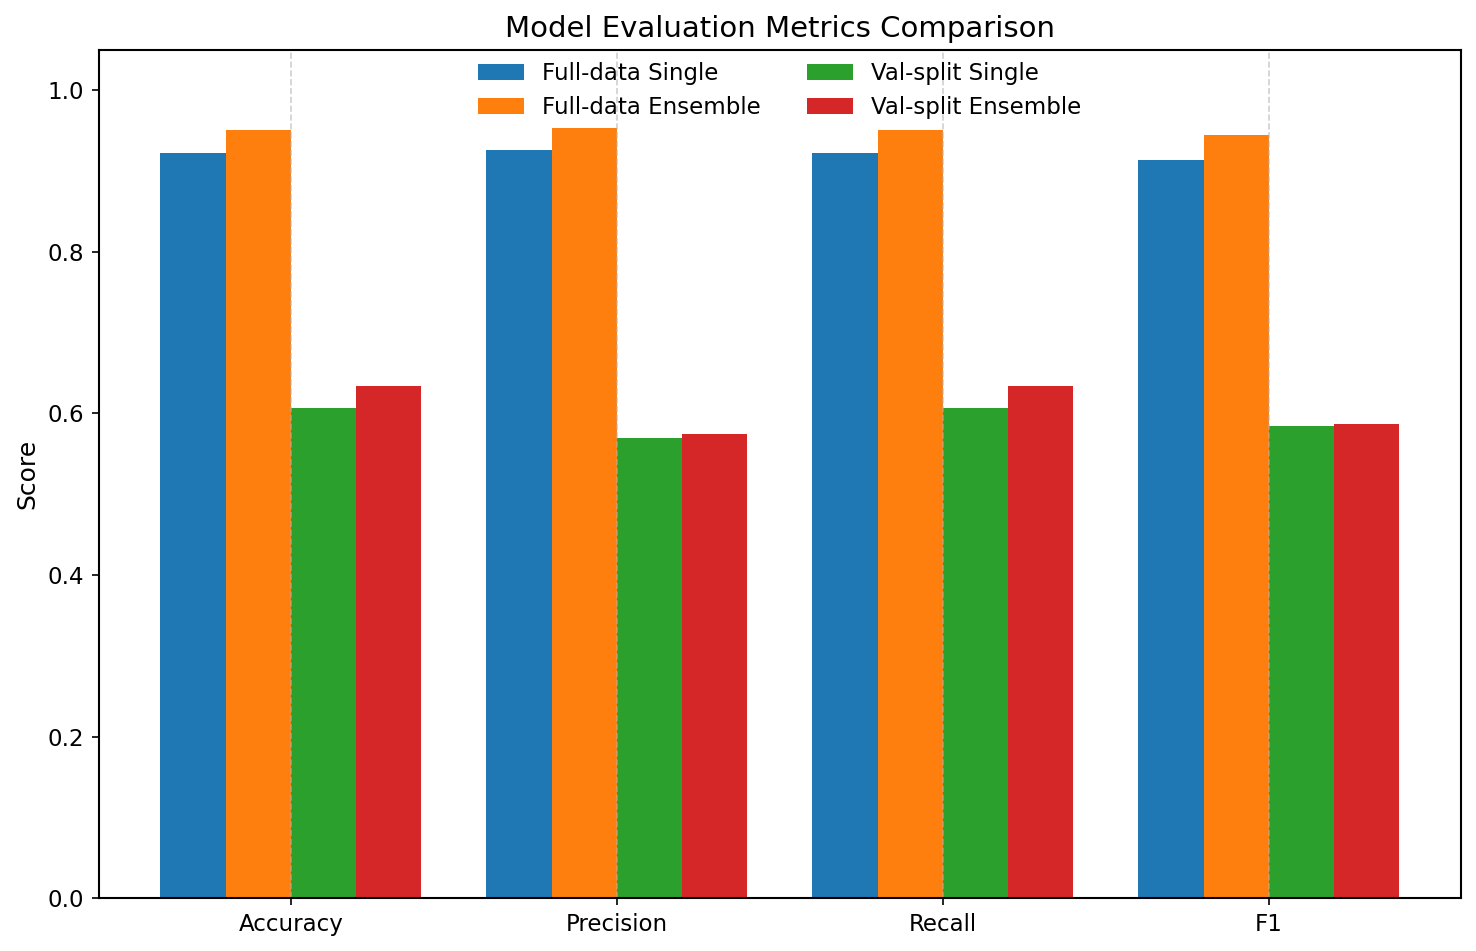

In [85]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(10, 6.5))
plt.bar(x - 1.5*width, full_single, width, label='Full-data Single')
plt.bar(x - 0.5*width, full_ensemble, width, label='Full-data Ensemble')
plt.bar(x + 0.5*width, val_single, width, label='Val-split Single')
plt.bar(x + 1.5*width, val_ensemble, width, label='Val-split Ensemble')

plt.ylabel('Score')
plt.title('Model Evaluation Metrics Comparison')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.01), 
    ncol=2,                      
    frameon=False
)
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [89]:
# Print the numbers here
print(f"Full-data single model accuracy: {full_single[0]:.4f}")
print(f"Full-data ensemble accuracy: {full_ensemble[0]:.4f}")
print(f"Val-split single model accuracy: {val_single[0]:.4f}")
print(f"Val-split ensemble accuracy: {val_ensemble[0]:.4f}")

print("\nFull-data single model precision: ", full_single[1])
print("Full-data ensemble precision: ", full_ensemble[1])
print("Val-split single model precision: ", val_single[1])
print("Val-split ensemble precision: ", val_ensemble[1])

print("\nFull-data single model recall: ", full_single[2])
print("Full-data ensemble recall: ", full_ensemble[2])
print("Val-split single model recall: ", val_single[2])
print("Val-split ensemble recall: ", val_ensemble[2])


Full-data single model accuracy: 0.9226
Full-data ensemble accuracy: 0.9504
Val-split single model accuracy: 0.6069
Val-split ensemble accuracy: 0.6334

Full-data single model precision:  0.9255996040667279
Full-data ensemble precision:  0.9534252789895195
Val-split single model precision:  0.5694829668602069
Val-split ensemble precision:  0.5749203449866052

Full-data single model recall:  0.9225967540574282
Full-data ensemble recall:  0.950374531835206
Val-split single model recall:  0.6068642745709828
Val-split ensemble recall:  0.6333853354134166


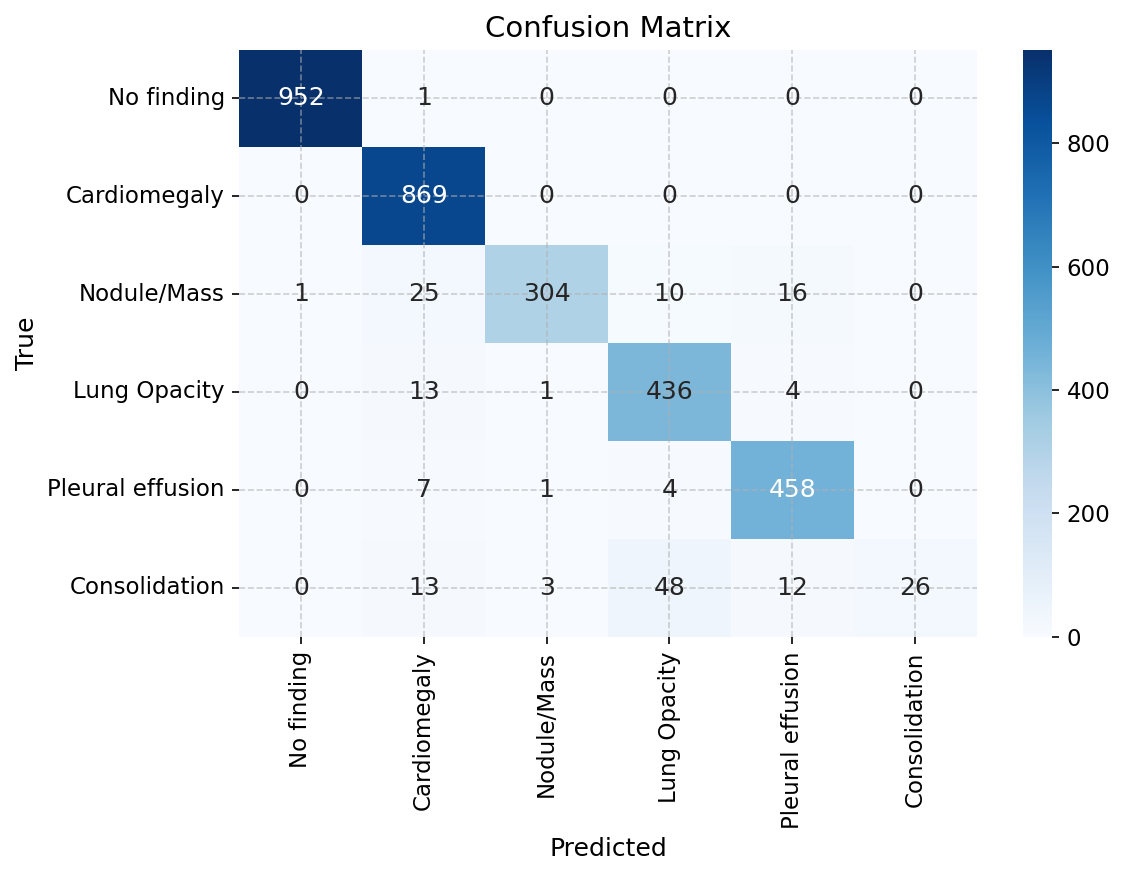

In [95]:
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_metrics['confusion_matrix'], annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [56]:
print(df_unique["label"].value_counts(normalize=True))
print(f"Total rows in df_unique: {len(df_unique)}")
print(df_unique["label"].value_counts(normalize=False))

label
0    0.297441
1    0.271223
4    0.146692
3    0.141698
2    0.111111
5    0.031835
Name: proportion, dtype: float64
Total rows in df_unique: 3204
label
0    953
1    869
4    470
3    454
2    356
5    102
Name: count, dtype: int64


**Expected Accuracy**

From these results, we can calculate our expected accuracies. (Similar to our calculations from the previous assignments)

Our expected accuracy from naively guessing each class w/ 1/6 chance is ~ 16.667%

If we have a proportional probability corresponding to image label size, then we have 

\sum_{i=0}^5 p_{i}^2 = 0.217

**Notes**
We see our single models have accuracy (of 80/20 split) of base 50.48%, and when ensembled it increases.

Ensembling has a slight increase in accuracy.

Also, it shows that this model performs better than random guessing, by a large margin. Considering the data size, resnet size, and number of epochs, this performance seems fine?

The full_data model might be overfit? That's something we need to test in against our OOD data.

**OUT OF DISTRIBUTION DATA**

In [58]:
# Load CheXpert CSV
chexpert_df = pd.read_csv("chexpert_subset.csv")
chexpert_dataset = XRayDataset("chexpert_resized", "chexpert_subset.csv")

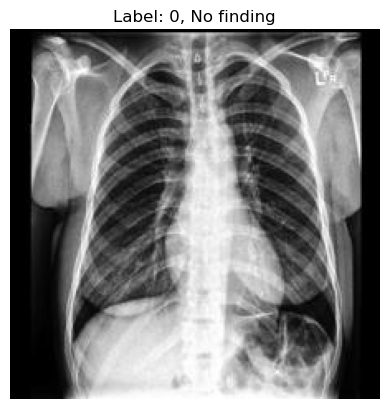

label
3    9736
4    8078
0    5499
1    2909
2    2122
5    1498
Name: count, dtype: int64
label
3    0.326252
4    0.270692
0    0.184270
1    0.097480
2    0.071108
5    0.050198
Name: proportion, dtype: float64


In [66]:
# Show an image from CheXpert dataset
show_image(*chexpert_dataset[0])

# Check the distribution of labels in CheXpert
print(chexpert_df["label"].value_counts(normalize=False))
print(chexpert_df["label"].value_counts(normalize=True))


Classification Report:
                  precision    recall  f1-score   support

      No finding       0.27      0.90      0.42      5499
    Cardiomegaly       0.16      0.40      0.23      2909
     Nodule/Mass       0.15      0.01      0.02      2122
    Lung Opacity       0.37      0.06      0.10      9736
Pleural effusion       0.43      0.15      0.22      8078
   Consolidation       0.00      0.00      0.00      1498

        accuracy                           0.27     29842
       macro avg       0.23      0.25      0.17     29842
    weighted avg       0.31      0.27      0.19     29842

OOD Accuracy: 0.2658
OOD Weighted Precision: 0.3134
OOD Weighted Recall: 0.2658
OOD Weighted F1: 0.1947

Per-Class Precision: [0.2744415  0.15997239 0.14876033 0.36700125 0.43184258 0.        ]
Per-Class Recall: [0.90252773 0.3984187  0.00848256 0.06008628 0.14941817 0.        ]
Per-Class F1: [0.42089641 0.22828442 0.01604993 0.10326567 0.22201784 0.        ]


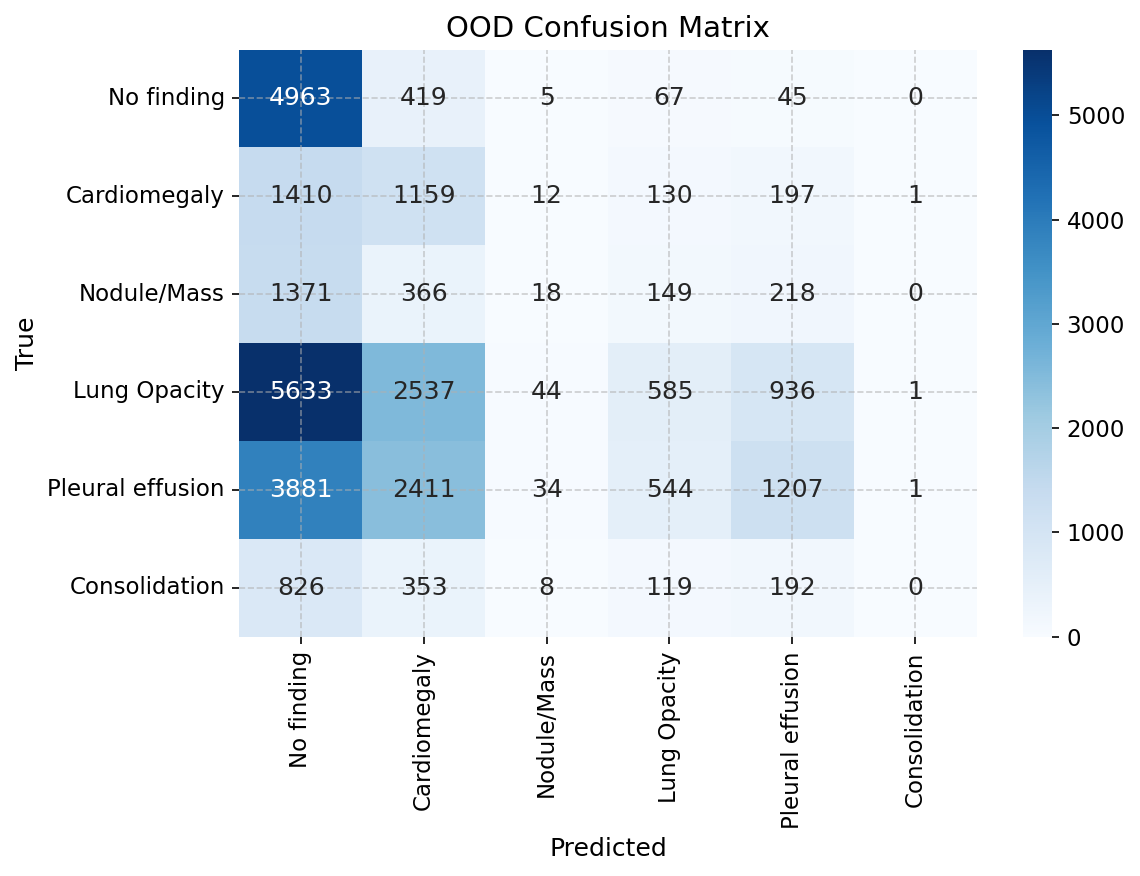

In [93]:
class_names = [name for name, _ in sorted(class_map.items(), key=lambda item: item[1])]
# Should just be ['No finding', 'Cardiomegaly', 'Nodule/Mass', 'Lung Opacity', 'Pleural effusion', 'Consolidation'] but in case it changes

# Evaluate full models, ensembled on CheXpert
ood_metrics = evaluate(model_list, chexpert_dataset, class_names=class_names)

print(f"OOD Accuracy: {ood_metrics['acc']:.4f}")
print(f"OOD Weighted Precision: {ood_metrics['prec']:.4f}")
print(f"OOD Weighted Recall: {ood_metrics['rec']:.4f}")
print(f"OOD Weighted F1: {ood_metrics['f1']:.4f}")
print("\nPer-Class Precision:", ood_metrics["per_class_prec"])
print("Per-Class Recall:", ood_metrics["per_class_rec"])
print("Per-Class F1:", ood_metrics["per_class_f1"])

plt.figure(figsize=(8,6))
sns.heatmap(ood_metrics['confusion_matrix'], annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("OOD Confusion Matrix")
plt.tight_layout()
plt.show()

In [97]:
print(len(chexpert_df))

chexpert_unique = chexpert_df.drop_duplicates(subset=["image_id"])
print(chexpert_unique["label"].value_counts(normalize=True))
print(f"Total rows in df_unique: {len(chexpert_unique)}")
print(chexpert_unique["label"].value_counts(normalize=False))


29842
label
3    0.326252
4    0.270692
0    0.184270
1    0.097480
2    0.071108
5    0.050198
Name: proportion, dtype: float64
Total rows in df_unique: 29842
label
3    9736
4    8078
0    5499
1    2909
2    2122
5    1498
Name: count, dtype: int64


Metrics for the 80/20 split model

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                  precision    recall  f1-score   support

      No finding       0.28      0.91      0.43      5499
    Cardiomegaly       0.16      0.48      0.24      2909
     Nodule/Mass       0.13      0.01      0.02      2122
    Lung Opacity       0.38      0.03      0.06      9736
Pleural effusion       0.42      0.10      0.16      8078
   Consolidation       0.00      0.00      0.00      1498

        accuracy                           0.25     29842
       macro avg       0.23      0.25      0.15     29842
    weighted avg       0.31      0.25      0.17     29842



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OOD Accuracy: 0.2530
OOD Weighted Precision: 0.3129
OOD Weighted Recall: 0.2530
OOD Weighted F1: 0.1671

Per-Class Precision: [0.27790484 0.15618003 0.13432836 0.38183935 0.41507538 0.        ]
Per-Class Recall: [0.90598291 0.47954624 0.00848256 0.0336894  0.10225303 0.        ]
Per-Class F1: [0.42533937 0.23562199 0.01595745 0.061916   0.16408423 0.        ]


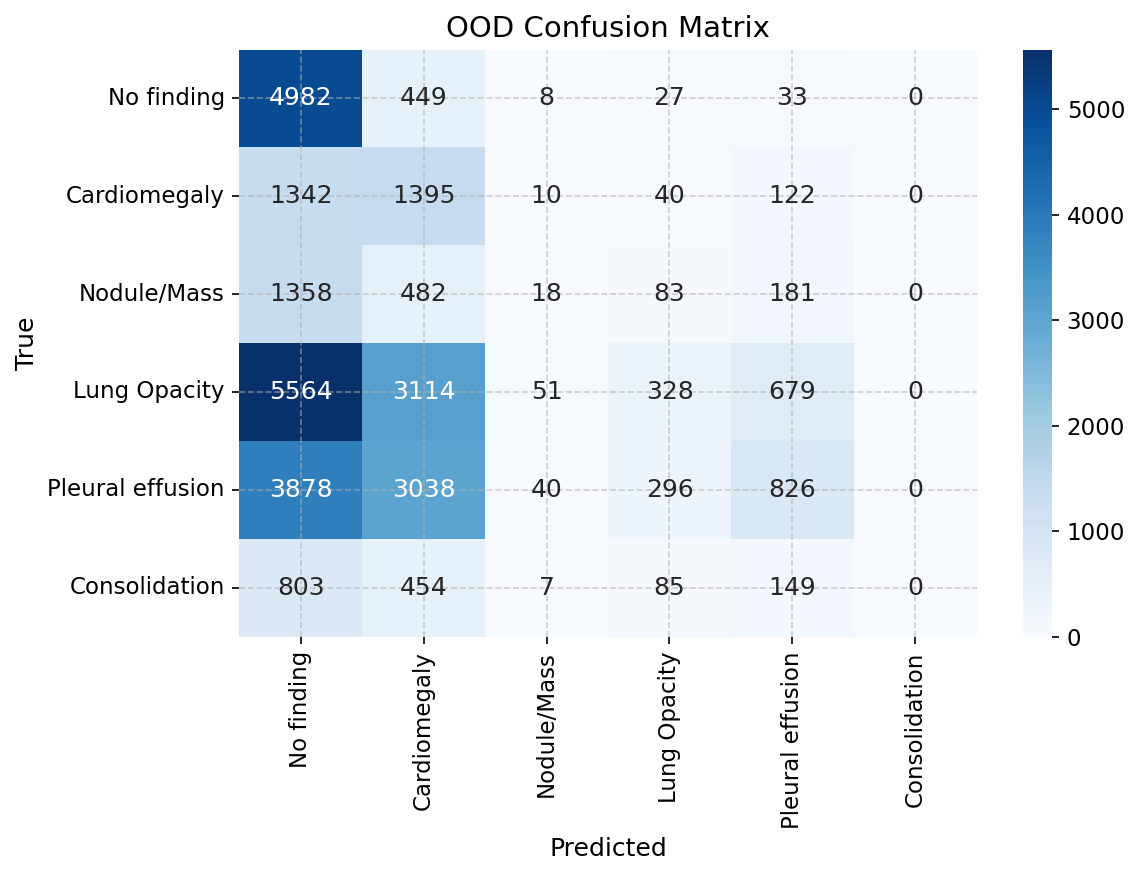

In [98]:

ood_split_metrics = evaluate(partial_models, chexpert_dataset, class_names=class_names)

print(f"OOD Accuracy: {ood_split_metrics['acc']:.4f}")
print(f"OOD Weighted Precision: {ood_split_metrics['prec']:.4f}")
print(f"OOD Weighted Recall: {ood_split_metrics['rec']:.4f}")
print(f"OOD Weighted F1: {ood_split_metrics['f1']:.4f}")
print("\nPer-Class Precision:", ood_split_metrics["per_class_prec"])
print("Per-Class Recall:", ood_split_metrics["per_class_rec"])
print("Per-Class F1:", ood_split_metrics["per_class_f1"])

plt.figure(figsize=(8,6))
sns.heatmap(ood_split_metrics['confusion_matrix'], annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("OOD Confusion Matrix")
plt.tight_layout()
plt.show()

In [67]:
# ood_acc, ood_prec, ood_rec, ood_f1 = evaluate(model_list, chexpert_dataset)
# print(f"OOD accuracy: {ood_acc:.4f}")
# print(f"OOD precision: {ood_prec:.4f}")
# print(f"OOD recall: {ood_rec:.4f}")

OOD accuracy: 0.2658
OOD precision: 0.3134
OOD recall: 0.2658


**Graphs/Data Analysis**